# Importing and Loading

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('Road_Traffic_Fine_Management_Process-training.csv')
df_test = pd.read_csv('Road_Traffic_Fine_Management_Process-test.csv')

In [3]:
df_train['event concept:name'].unique()

array(['Create Fine', 'Payment', 'Send Fine', 'Insert Fine Notification',
       'Add penalty', 'Insert Date Appeal to Prefecture',
       'Send Appeal to Prefecture',
       'Receive Result Appeal from Prefecture',
       'Notify Result Appeal to Offender', 'Appeal to Judge',
       'Send for Credit Collection'], dtype=object)

# Dot plot all processes

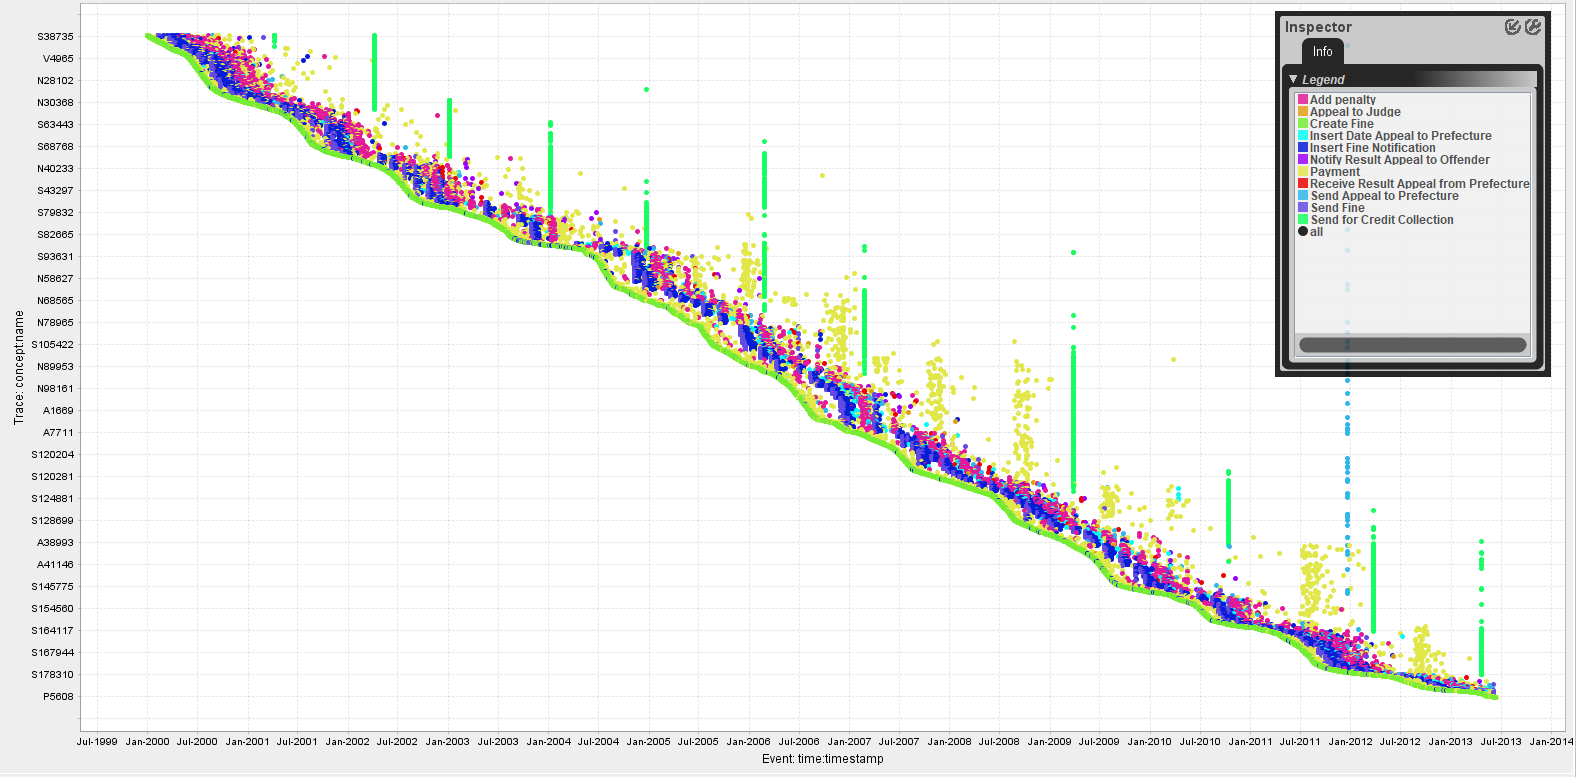

# Looking at times for the ''send for credit collection'' event

In [4]:
df_train['event time:timestamp'] = pd.to_datetime(df_train['event time:timestamp'])
time = df_train[df_train['event concept:name'] == 'Send for Credit Collection'].groupby('event time:timestamp').count()
time

,eventID,case concept:name,event concept:name,event lifecycle:transition
event time:timestamp,,,,
2001-10-04,247,247,247,247
2002-10-04,5677,5677,5677,5677
2003-10-01,2956,2956,2956,2956
2004-10-01,2014,2014,2014,2014
2004-12-25,1973,1973,1973,1973
2006-02-28,3232,3232,3232,3232
2007-02-28,4304,4304,4304,4304
2009-03-30,8560,8560,8560,8560
2010-10-15,4724,4724,4724,4724


# Looking at times for the ''send appeal to prefecture'' event

In [5]:
df_train[df_train['event concept:name'] == 'Send Appeal to Prefecture'].groupby('event time:timestamp').count()

,eventID,case concept:name,event concept:name,event lifecycle:transition
event time:timestamp,,,,
2000-01-09,2,2,2,2
2000-03-08,5,5,5,5
2000-03-21,1,1,1,1
2000-03-29,4,4,4,4
2000-04-26,1,1,1,1
...,...,...,...,...
2013-08-02,5,5,5,5
2013-08-03,2,2,2,2
2013-08-04,1,1,1,1


# Look for similar processes

In [6]:
def encode(train_df, test_df):
    df = train_df.append(test_df) # use the whole dataset
    unique_events = df['event concept:name'].unique()
    # encode each event with a number
    codes = {i/100+0.01: name for i, name in enumerate(unique_events)}
    reverse_codes = {value: key for (key, value) in codes.items()}
    return codes, reverse_codes


def dataProcessor(df, encoder):
    df = df[['eventID ', 'case concept:name', 
        'event concept:name', 'event time:timestamp']]
    ## Converting to timestamp, to seconds
    df['event time:timestamp'] = pd.to_datetime(df['event time:timestamp'])
    df.loc[:, 'event time:timestamp'] = (df['event time:timestamp'] 
        - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') 
    df = df.sort_values(by=['case concept:name', 'event time:timestamp'])

    ## Stuff to potentially add later:
    # Account for time
    # Add more training features in this step
    #   + this would require a more complicated encoder

    # rename 
    df['event concept:name'] = df['event concept:name'].map(encoder)

    # Add an event counter for each case

    df['n_event'] = df.groupby(['case concept:name'])['eventID '].cumcount()
    
    cases_df = df.pivot(columns='n_event', index='case concept:name', 
        values='event concept:name').fillna(0)\
                                    .astype('category')\
                                    .reset_index(drop=True)
    return cases_df

In [7]:
def Filter(pos, cases_df):
  cases_df = cases_df[cases_df[pos] != 0]
  return cases_df.loc[:, :pos-1], cases_df.loc[:, pos]

In [8]:
decoder, encoder = encode(df_train, df_test)
df_train = dataProcessor(df_train, encoder)
df_test  = dataProcessor(df_test, encoder)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()
C:\Users\20183339\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Counting of each identical process

In [9]:
df_count = df_train.groupby(df_train.columns.tolist(),as_index=True).size()
df_count.sort_values(ascending=False)[0:] 

0     1     2     3     4     5     6     7     8     9     10   11   12   13   14   15   16   17   18   19 
0.01  0.02  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    29233
      0.03  0.04  0.05  0.11  0.00  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    19845
            0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    14188
0.02  0.01  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     9829
0.03  0.01  0.04  0.05  0.11  0.00  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     3528
                                                                                                                ...  
0.01  0.08  0.03  0.04  0.07  0.06  0.05  0.09  0.02  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1
                        0.06  0.09  0.05  0.07  0.02  0.00  0.0  

# Top 10 most occuring processes

In [10]:
df_count.sort_values(ascending=False)[0:10] 

0     1     2     3     4     5    6    7    8    9    10   11   12   13   14   15   16   17   18   19 
0.01  0.02  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    29233
      0.03  0.04  0.05  0.11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    19845
            0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    14188
0.02  0.01  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     9829
0.03  0.01  0.04  0.05  0.11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     3528
0.01  0.03  0.04  0.05  0.02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     3443
0.03  0.01  0.00  0.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     3210
0.01  0.04  0.03  0.05  0.11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

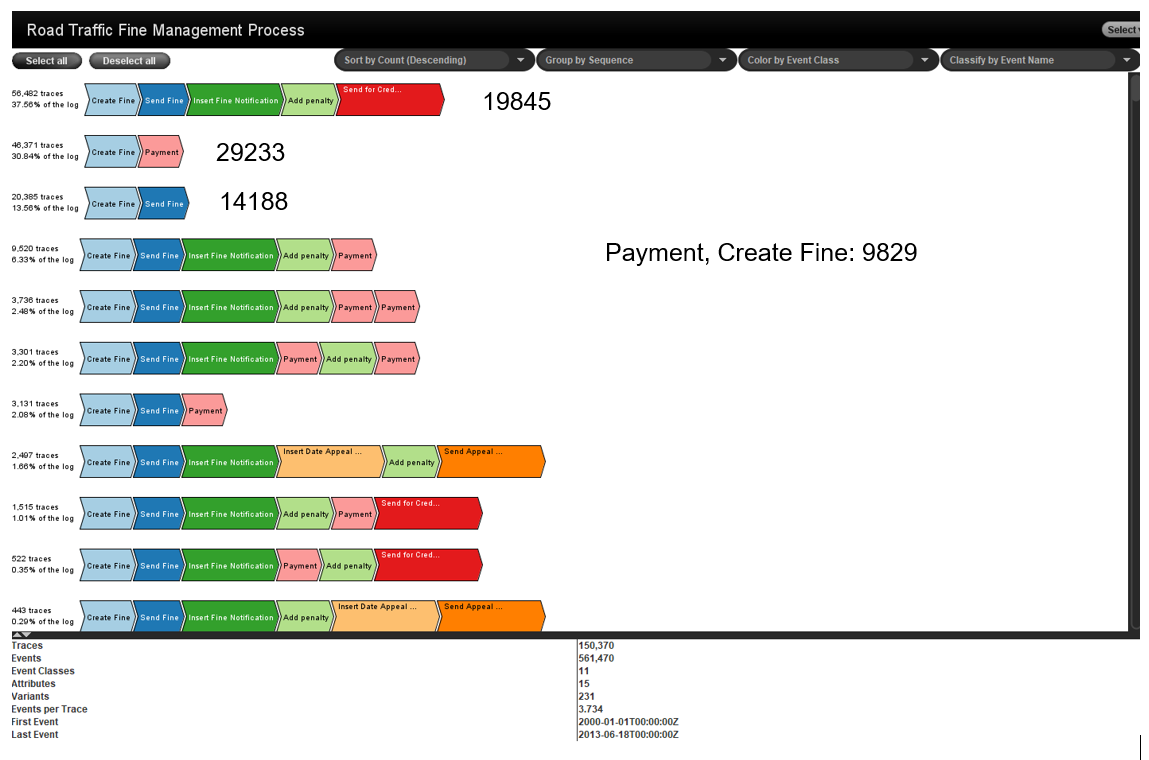